# Enhancing Digit Recognition: Exploring SVM and HOG Features with MNIST
In this notebook, I explore the application of block wise histograms of local orientation gradients (HOG) on the MNIST data, as presented in the paper by Maji & Malik, 2009. 
This technique showed results close to the state of the art preformance using SVMs even with a relatively simple classifier like linear SVMs, and in a fairly high speed.

## Features extraction 

I constructed 12-bin orientation histograms 
witha  cell siz ofd 4×4 withan  overlap of half the cell size

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



data_mnist = np.load('mnist-data.npz')

def hog_features(train_data):

    reshaped_data = train_data.reshape(-1, 28, 28)
    
    win_size = reshaped_data[0].shape
    cell_size = (4, 4)
    block_size = (8, 8)
    block_stride = (4, 4)
    num_bins = 12
    
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
    
    num_images = reshaped_data.shape[0]
    image_size = len(hog.compute(reshaped_data[0].astype(np.uint8)))
    print(image_size)
    
    hog_training_data = np.zeros((num_images, image_size))
    
    for i, image in enumerate(reshaped_data):
        try:
            hog_descriptor = hog.compute(image.astype(np.uint8))
            hog_training_data[i] = hog_descriptor
        except Exception as e:
            print(f"Error processing image {i}: {e}")
    return hog_training_data

In [11]:
def accuracy_plot(x_values, training_accuracy_list, validation_accuracy_list, plot_info):
    
    plt.figure(figsize=(10, 6))

    if training_accuracy_list:
        plt.semilogx(x_values, training_accuracy_list, 'b-o', label='training accuracy')
	
    if validation_accuracy_list:
        plt.semilogx(x_values, validation_accuracy_list, 'r-o', label='validation accuracy')

    plt.title(plot_info['title'])

    plt.xlabel(plot_info['x_label'])
    plt.ylabel(plot_info['y_label'])
    
    plt.legend()
    
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

## Training the Linear SVMs on diffrent training samples

In my experiments, using HOG features with linear SVMs boosted accuracy from about 92% with raw pixels to around 98%.

1728


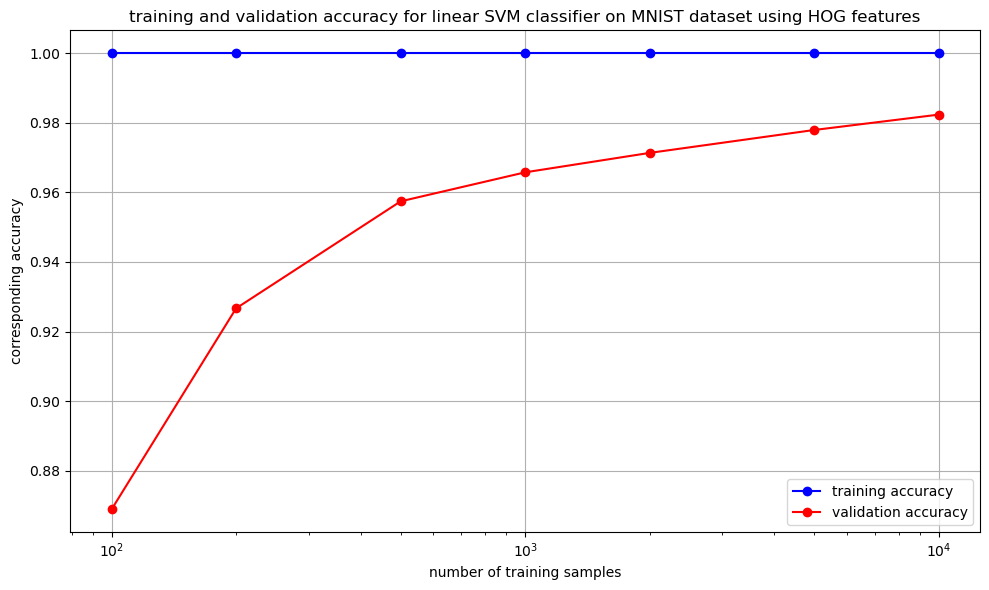

In [12]:
hog_training = {
		'data': hog_features(data_mnist['training_data']),
		'labels': data_mnist['training_labels']
}

mnist_x = [100, 200, 500, 1000, 2000, 5000, 10000]

training_data, validation_data, training_labels, validation_labels = train_test_split(hog_training['data'], 
                                                                                      hog_training['labels'],
                                                                                      test_size=0.2, 
                                                                                      random_state=42)

training_accuracy_list = []
validation_accuracy_list = []


for split_index in mnist_x:
    mnist_clf = svm.SVC(kernel='linear')
    mnist_clf.fit(training_data[:split_index], training_labels[:split_index])
    
    training_predictions = mnist_clf.predict(training_data[:split_index])
    validation_predictions = mnist_clf.predict(validation_data)
    
    training_accuracy_list.append(accuracy_score(training_labels[:split_index], training_predictions))
    validation_accuracy_list.append(accuracy_score(validation_labels, validation_predictions))

plot_info = {
    'title': 'training and validation accuracy for linear SVM classifier on MNIST dataset using HOG features' ,
    'x_label': 'number of training samples',
    'y_label': 'corresponding accuracy'
}

accuracy_plot(mnist_x, training_accuracy_list, validation_accuracy_list, plot_info)